# FinRL Full Workflow — Daily Rebalancing

This notebook demonstrates a **daily ML stock selection pipeline** — combining quarterly fundamental ratios with daily technical indicators to predict next-day returns, then rebalancing a portfolio every trading day.

## How It Works

1. **Fetch Fundamentals** — Download quarterly financial ratios (EPS, P/E, ROE, debt ratios, etc.) for all S&P 500 stocks from Yahoo Finance. These are updated once per quarter when new earnings data becomes available.

2. **Fetch Daily Prices & Compute Features** — Download daily price data and compute technical indicators: momentum (5/10/20-day), volatility (20/60-day), moving averages (SMA 5/10/20/50/200), RSI (14-day), and MACD. Each daily row is merged with the most recent quarterly fundamentals via `merge_asof`, giving the model ~26 features per stock per day.

3. **ML Stock Selection (Daily)** — Train a LightGBM model on the combined daily+fundamental features to predict next-day forward log returns. The model trains on ~504 trading days (2 years) of history and validates on ~63 days (1 quarter). Select the top 10% of stocks (`top_quantile=0.9`) and assign equal weights.

4. **Backtest** — Run a daily-rebalanced backtest using the `bt` library, comparing the ML portfolio against SPY and QQQ benchmarks.

5. **Paper Trading** — Submit the daily portfolio weights as orders to Alpaca paper trading.

## How Often to Run Each Section

This is a **daily rebalancing strategy**. The recommended cadence:

| Section | How Often | When |
|---------|-----------|------|
| **Fetch Fundamentals** (Cell 6) | Once per quarter | ~2 months after quarter ends (end of Feb/May/Aug/Nov) |
| **Fetch Daily Prices & Features** (Cell 8) | Daily | Each trading day before ML selection |
| **ML Stock Selection** (Cell 10) | Daily | After computing daily features |
| **Backtest** (Cell 12) | After each ML run | Sanity check on cumulative performance |
| **Paper Trading** (Cells 14-16) | Daily | Rebalance portfolio each trading day |
| **Performance Analysis** (Cell 17) | Anytime | Check portfolio performance vs benchmarks |
| **Cancel Orders** (Cell 19) | As needed | Only to revoke pending orders |

### Typical Daily Workflow

```
Each trading day (before market open):
  1. Run Cells 1-8   (fetch fresh daily prices + compute features)
  2. Run Cell 10     (generate today's stock picks via daily ML)
  3. Run Cell 12     (backtest sanity check — optional, can skip on busy days)
  4. Run Cells 14-16 (submit rebalance orders to Alpaca)

Once per quarter (late Feb / May / Aug / Nov):
  1. Run Cells 1-6   (refresh quarterly fundamentals from Yahoo Finance)
  2. Then continue with the daily cycle above
```

## Data Sources & Features

- **Yahoo Finance** for both fundamental and price data — no API key required.
- **Quarterly features** (14): EPS, BPS, DPS, current/quick/cash ratios, debt ratio, debt-to-equity, P/E, P/S, P/B, ROE, net income ratio.
- **Daily technical features** (~12): momentum (5d/10d/20d), volatility (20d/60d), SMA (5/10/20/50/200), RSI-14, MACD, MACD signal.
- **Target variable**: next-day forward log return.

## Prerequisites

- Install dependencies: run `pip install -r requirements.txt` from the project root
- Alpaca API keys are only needed for paper trading (Cells 14+). Cells 1-12 work without any API keys.
- To use Alpaca, configure `.env` (see `README.md` / `.env.example`)
- The first run will generate cache files in `data/cache/` to avoid redundant data fetching
- Research window is ~4 years (need 200+ days for SMA-200 warmup + 568 days for training/validation/prediction)

---

In [1]:
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
%cd "~/Downloads/FinRL-Trading\.claude\worktrees\xenodochial-khayyam"

C:\Users\vrang\Downloads\FinRL-Trading\.claude\worktrees\xenodochial-khayyam


In [ ]:
# # Environment and path setup
# import os, sys, logging
# from datetime import datetime, timedelta
# from pathlib import Path

# # Infer project root from working directory (this file is in examples/)
# nb_dir = Path().resolve()
# project_root = str(nb_dir.parent)
# print(f"project_root: {project_root}")
# if project_root not in sys.path:
#     sys.path.insert(0, project_root)
#     sys.path.insert(0, os.path.join(project_root, 'src'))

# logging.basicConfig(level=logging.INFO)


In [3]:
# Data source initialization and stock universe / date range setup
from src.data.data_fetcher import get_data_manager, fetch_sp500_tickers
from datetime import datetime, timedelta

# Initialize the data manager with Yahoo Finance (no API key required)
manager = get_data_manager(preferred_source='YAHOO')
print(manager.get_source_info())

# Fetch S&P 500 components (falls back to a default list on failure)
tickers = fetch_sp500_tickers(preferred_source='YAHOO')
print(f"Total tickers: {len(tickers)} (show first 15)")
print(tickers.head(15))

# Research time period (~4 years — need 200+ days for SMA-200 warmup + 568 days for train/val/predict)
end_date_dt = datetime.now()
start_date_dt = end_date_dt - timedelta(days=int(4 * 365))

start_date = start_date_dt.strftime('%Y-%m-%d')
end_date = end_date_dt.strftime('%Y-%m-%d')
print(f"Research period: {start_date} -> {end_date}")

project_root: C:\Users\vrang\Downloads\FinRL-Trading\.claude\worktrees\xenodochial-khayyam
project_root: C:\Users\vrang\Downloads\FinRL-Trading\.claude\worktrees\xenodochial-khayyam
{'current_source': 'YAHOO', 'available_sources': ['FMP', 'YAHOO'], 'cache_dir': './data/cache'}


C:\Users\vrang\Downloads\FinRL-Trading\.claude\worktrees\xenodochial-khayyam\src\data\data_fetcher.py:1062: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


Total tickers: 503 (show first 15)
   tickers                 sectors dateFirstAdded
0      MMM             Industrials     1957-03-04
1      AOS             Industrials     2017-07-26
2      ABT             Health Care     1957-03-04
3     ABBV             Health Care     2012-12-31
4      ACN  Information Technology     2011-07-06
5     ADBE  Information Technology     1997-05-05
6      AMD  Information Technology     2017-03-20
7      AES               Utilities     1998-10-02
8      AFL              Financials     1999-05-28
9        A             Health Care     2000-06-05
10     APD               Materials     1985-04-30
11    ABNB  Consumer Discretionary     2023-09-18
12    AKAM  Information Technology     2007-07-12
13     ALB               Materials     2016-07-01
14     ARE             Real Estate     2017-03-20
Research period: 2022-02-16 -> 2026-02-15


## Stage 1 — Fetch Fundamentals

Download quarterly financial ratios (EPS, P/E, ROE, debt ratios, etc.) for S&P 500 stocks from Yahoo Finance.
The fetcher computes `y_return` (log return to the next quarter) and optionally aligns dates to avoid look-ahead bias.

Saved to `data/fundamentals.csv` for reuse in subsequent stages.

**When to run:** Once per quarter, ~2 months after the quarter ends (late Feb / May / Aug / Nov), when new earnings data is available.

In [4]:
# Fetch fundamental data — with CSV cache check
import pandas as pd
import os
from src.data.data_fetcher import fetch_fundamental_data

clean_path = 'data/fundamentals.csv'
need_fetch = True

# Check if cached CSV already covers the needed tickers and dates
if os.path.exists(clean_path):
    existing = pd.read_csv(clean_path)
    existing['datadate'] = pd.to_datetime(existing['datadate'])

    tickers_list = tickers['tickers'].tolist() if isinstance(tickers, pd.DataFrame) else list(tickers)
    tickers_in_csv = set(existing['tic'].unique())
    tickers_covered = sum(1 for t in tickers_list if t in tickers_in_csv)
    coverage_pct = tickers_covered / len(tickers_list) * 100

    date_min = existing['datadate'].min()
    date_max = existing['datadate'].max()

    # Accept if >=95% of tickers present and y_return exists
    if coverage_pct >= 95 and 'y_return' in existing.columns:
        print(f"Found existing {clean_path}: {len(existing)} rows, {len(tickers_in_csv)} tickers")
        print(f"  Ticker coverage: {tickers_covered}/{len(tickers_list)} ({coverage_pct:.0f}%)")
        print(f"  Date range: {date_min.date()} to {date_max.date()}")
        print(f"  Skipping Yahoo Finance fetch (takes ~7 min). Delete {clean_path} to force refresh.")
        fundamentals = existing
        need_fetch = False
    else:
        print(f"Found {clean_path} but coverage insufficient ({coverage_pct:.0f}% tickers). Re-fetching...")

if need_fetch:
    fundamentals = fetch_fundamental_data(
        tickers,
        start_date,
        end_date,
        align_quarter_dates=True,    # Shift trade dates ~2 months after earnings release to align across companies
        preferred_source='YAHOO'     # Use Yahoo Finance (no API key needed)
    )
    print(f"fundamentals shape: {fundamentals.shape}")

    # Basic validation: must contain y_return (next-quarter return computed by fetcher)
    if 'y_return' not in fundamentals.columns:
        raise ValueError("fundamentals missing y_return — check data_fetcher implementation")

    # Drop sector/gsector columns — not used for basic ML stock selection
    for col in ['sector', 'gsector']:
        if col in fundamentals.columns:
            fundamentals = fundamentals.drop(columns=[col])
            print(f"Dropped '{col}' column from fundamentals")

    # Save a clean copy of the data
    fundamentals.to_csv(clean_path, index=False)
    print(f"Saved cleaned fundamentals to {clean_path}")

print(f"Columns: {list(fundamentals.columns)}")

Fetching Yahoo Finance data: 100%|███████████████████████████████████████████████████| 503/503 [07:46<00:00,  1.08it/s]


fundamentals shape: (2794, 20)
Dropped 'gsector' column from fundamentals
Saved cleaned fundamentals to data/fundamentals.csv
Columns: ['gvkey', 'datadate', 'tic', 'adj_close_q', 'EPS', 'BPS', 'DPS', 'cur_ratio', 'quick_ratio', 'cash_ratio', 'acc_rec_turnover', 'debt_ratio', 'debt_to_equity', 'pe', 'ps', 'pb', 'roe', 'net_income_ratio', 'y_return']


## Stage 1b — Fetch Daily Prices & Compute Features

Fetch daily price data for all S&P 500 tickers and compute technical indicators:
momentum (5/10/20-day), volatility (20/60-day), moving averages (SMA 5–200), RSI-14, and MACD.

Each daily row is then merged with the most recent quarterly fundamentals using `merge_asof`,
so every row has both daily technicals and quarterly ratios as features.

The forward 1-day log return (`y_return`) is computed as the ML prediction target.

**When to run:** Every trading day, before running ML stock selection.

In [5]:
# Fetch daily prices and compute technical indicators + merge with fundamentals

# Re-derive tickers/dates if not already in kernel (e.g. after kernel restart)
try:
    tickers
except NameError:
    from src.data.data_fetcher import fetch_sp500_tickers
    from datetime import datetime, timedelta
    tickers = fetch_sp500_tickers(preferred_source='YAHOO')
    end_date_dt = datetime.now()
    start_date_dt = end_date_dt - timedelta(days=int(4 * 365))
    start_date = start_date_dt.strftime('%Y-%m-%d')
    end_date = end_date_dt.strftime('%Y-%m-%d')
    print(f"Re-derived: {len(tickers)} tickers, {start_date} -> {end_date}")

import pandas as pd
from src.data.data_fetcher import fetch_price_data
from src.data.data_processor import compute_daily_features, merge_daily_with_fundamentals

# Fetch daily price data for all S&P 500 tickers
prices = fetch_price_data(tickers, start_date, end_date, preferred_source='YAHOO')
print(f"Daily prices: {prices.shape[0]} rows, {prices['tic'].nunique()} tickers")

# Compute daily technical indicators and forward 1-day return (y_return)
daily_features = compute_daily_features(prices)
print(f"Daily features after warmup removal: {daily_features.shape}")

# Merge with quarterly fundamentals (forward-fill latest quarter's ratios to each daily row)
fundamentals = pd.read_csv('data/fundamentals.csv')
daily_data = merge_daily_with_fundamentals(daily_features, fundamentals)
print(f"Merged daily+fundamental data: {daily_data.shape}")
print(f"Feature columns: {[c for c in daily_data.columns if c not in ['gvkey','tic','datadate','y_return','adj_close','prccd','prcod','prchd','prcld','cshtrd']]}")

# Save for reuse
daily_data.to_csv('data/daily_features.csv', index=False)
print(f"Saved to data/daily_features.csv")

Fetching Yahoo price data: 100%|█████████████████████████████████████████████████████| 503/503 [01:08<00:00,  7.39it/s]


Daily prices: 500350 rows, 503 tickers
Daily features after warmup removal: (400376, 24)
Merged daily+fundamental data: (400376, 38)
Feature columns: ['daily_return', 'momentum_5d', 'momentum_10d', 'momentum_20d', 'volatility_20d', 'volatility_60d', 'sma_5', 'sma_10', 'sma_20', 'sma_50', 'sma_200', 'rsi_14', 'macd', 'macd_signal', 'EPS', 'BPS', 'DPS', 'cur_ratio', 'quick_ratio', 'cash_ratio', 'acc_rec_turnover', 'debt_ratio', 'debt_to_equity', 'pe', 'ps', 'pb', 'roe', 'net_income_ratio']
Saved to data/daily_features.csv


## Stage 2 — Daily ML Stock Selection

Train a LightGBM model on ~26 features (14 quarterly fundamentals + ~12 daily technicals) to predict next-day forward log returns. Stocks in the top 10% (`top_quantile=0.9`) receive equal weights. Results are saved to `data/ml_weights_today.csv`.

- **`frequency='daily'`** — Uses the daily training path with combined features.
- **`train_days=504`** — Training window of ~2 years of trading days.
- **`val_days=63`** — Validation window of ~1 quarter (63 trading days).
- **Target**: `y_return` = forward 1-day log return.

**When to run:** Every trading day, after computing daily features.

In [6]:
# Daily ML stock selection and save weights CSV
from src.strategies.base_strategy import StrategyConfig
from src.strategies.ml_strategy import MLStockSelectionStrategy
import os
import pandas as pd

# Load daily features (daily technicals merged with quarterly fundamentals)
daily_data = pd.read_csv('data/daily_features.csv')
print(f"Loaded daily features: {daily_data.shape[0]} rows, {daily_data.shape[1]} columns")

# Load fundamentals for reference (used by weight allocation if min_variance)
fundamentals = pd.read_csv('data/fundamentals.csv')

config = StrategyConfig(
    name="Daily ML Stock Selection",
    description="Daily ML stock selection using technical + fundamental features"
)
strategy = MLStockSelectionStrategy(config)

data_dict = {
    'fundamentals': fundamentals,
    'daily': daily_data,
}

# Strategy parameters — daily mode
train_days = 504       # ~2 years of trading days
val_days = 63          # ~1 quarter for validation
top_quantile = 0.9     # Top 10% of stocks by predicted return

# Run daily ML stock selection
res = strategy.generate_weights(
    data=data_dict,
    frequency='daily',
    train_days=train_days,
    val_days=val_days,
    top_quantile=top_quantile,
    weight_method='equal',
)

weights = res.weights.copy()
print(f"weights rows: {len(weights)}")
print(f"Metadata: model={res.metadata.get('model_name')}, MSE={res.metadata.get('model_mse', 'N/A')}")

# Save weights
out_dir = 'data'
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'ml_weights_today.csv')
weights.to_csv(out_path, index=False)
print(f"Saved weights to {out_path}")

project_root: C:\Users\vrang\Downloads\FinRL-Trading\.claude\worktrees\xenodochial-khayyam
Loaded daily features: 400376 rows, 38 columns
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 251674, number of used features: 28
[LightGBM] [Info] Start training from score 0.000651


C:\Users\vrang\Downloads\FinRL-Trading\.claude\worktrees\xenodochial-khayyam\.finrl_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


weights rows: 51
Metadata: model=gbm, MSE=0.0004763618121423272
Saved weights to data\ml_weights_today.csv


## Stage 3 — Daily Backtest

Run a daily-rebalanced backtest of the ML-selected portfolio weights using the **bt** library.
The portfolio rebalances on each weight date, and weights are forward-filled to all trading days.
Compares annualized return, Sharpe ratio, and drawdown against SPY and QQQ benchmarks.

**When to run:** After each daily ML run — serves as a cumulative performance sanity check.

In [7]:
# Backtest weights using the bt library and output metrics
import pandas as pd
from datetime import datetime, timedelta
from src.backtest.backtest_engine import BacktestConfig, BacktestEngine
from src.data.data_fetcher import fetch_price_data

# Load weights
weights_path = 'data/ml_weights_today.csv'  # From previous cell
weights_raw = pd.read_csv(weights_path)
assert {'date','gvkey','weight'}.issubset(weights_raw.columns), 'Weight file must contain date/gvkey/weight'
weights_raw['date'] = pd.to_datetime(weights_raw['date'])
weights_raw['gvkey'] = weights_raw['gvkey'].astype(str)
weights_raw = weights_raw.sort_values(['date','gvkey'])

# Create weight matrix (rows: dates, columns: tickers)
weight_signals = (
    weights_raw
    .pivot_table(index='date', columns='gvkey', values='weight', aggfunc='sum')
    .fillna(0.0)
    .sort_index()
)

# Filter out rows where all weights are zero
weight_signals = weight_signals.loc[(weight_signals.sum(axis=1) > 0.0)]
assert len(weight_signals) > 0, 'Weight matrix is empty — cannot run backtest'

# Backtest time period
# Extend start date 90 days before earliest weight and end date to today
# so bt has enough price history and can align weight dates to trading days
t_min = weight_signals.index.min()
t_max = weight_signals.index.max()
t_start = (t_min - timedelta(days=90)).strftime('%Y-%m-%d')
t_end = datetime.now().strftime('%Y-%m-%d')

print(f"Weight dates: {t_min.strftime('%Y-%m-%d')} to {t_max.strftime('%Y-%m-%d')}")
print(f"Price data range: {t_start} to {t_end}")

cfg = BacktestConfig(
    start_date=t_start,
    end_date=t_end,
    rebalance_freq='D',    # Daily rebalancing
    initial_capital=1000000.0
)

# Fetch price data from Yahoo Finance
tickers_bt = weight_signals.columns.tolist()
prices_long = fetch_price_data(tickers_bt, cfg.start_date, cfg.end_date, preferred_source='YAHOO')

if prices_long is None or len(prices_long) == 0:
    raise ValueError(f'No price data fetched for {len(tickers_bt)} tickers between {t_start} and {t_end}')
print(f"Fetched price data: {len(prices_long)} rows for {prices_long['gvkey'].nunique()} tickers")

# Run backtest
engine = BacktestEngine(cfg)
price_data_bt = engine._prepare_price_data_for_bt(prices_long)
print(f"Price matrix: {price_data_bt.shape[0]} trading days, {price_data_bt.shape[1]} tickers")
print(f"Price date range: {price_data_bt.index.min().strftime('%Y-%m-%d')} to {price_data_bt.index.max().strftime('%Y-%m-%d')}")

# Align weight dates to nearest available trading day
# Use 'nearest' so weights snap to the closest trading day in the price data
from pandas import DataFrame
common_cols = [c for c in weight_signals.columns if c in price_data_bt.columns]
if len(common_cols) == 0:
    raise ValueError(
        f'No overlapping tickers between weights ({list(weight_signals.columns[:5])}) '
        f'and prices ({list(price_data_bt.columns[:5])})'
    )
weight_signals = weight_signals[common_cols]
trading_index = price_data_bt.index
pos = trading_index.get_indexer(weight_signals.index, method='nearest')
mask = pos != -1
weight_signals = weight_signals.iloc[mask]
weight_signals.index = trading_index[pos[mask]]

# Remove stocks with no price on each date and normalize
aligned = []
for dt, row in weight_signals.iterrows():
    prices_today = price_data_bt.loc[dt, row.index]
    valid_cols = prices_today.dropna().index.tolist()
    if len(valid_cols) == 0:
        continue
    row_valid = row[valid_cols]
    s = row_valid.sum()
    if s <= 0:
        continue
    aligned.append((dt, (row_valid / s)))

if aligned:
    weight_signals = DataFrame({dt: vec for dt, vec in aligned}).T.sort_index()
else:
    raise ValueError('No valid weight rows after alignment')

# Normalize rows again
weight_signals = weight_signals.div(weight_signals.sum(axis=1), axis=0).fillna(0)

result = engine.run_backtest('Daily ML Strategy', prices_long, weight_signals)
print(f"Backtest period: {t_start} to {t_end}")
print(f"Portfolio annualized return: {result.annualized_return:.2%}")
for bm, ann in (result.benchmark_annualized or {}).items():
    print(f"Benchmark {bm} annualized return: {ann:.2%}")

metrics_df = result.to_metrics_dataframe()
metrics_df

project_root: C:\Users\vrang\Downloads\FinRL-Trading\.claude\worktrees\xenodochial-khayyam
Weight dates: 2026-02-13 to 2026-02-13
Price data range: 2025-11-15 to 2026-02-16


Fetching Yahoo price data: 100%|███████████████████████████████████████████████████████| 51/51 [00:04<00:00, 12.04it/s]


Fetched price data: 3111 rows for 51 tickers
Price matrix: 61 trading days, 51 tickers
Price date range: 2025-11-17 to 2026-02-13


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.14it/s]
C:\Users\vrang\Downloads\FinRL-Trading\.claude\worktrees\xenodochial-khayyam\src\backtest\backtest_engine.py:349: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.53it/s]
C:\Users\vrang\Downloads\FinRL-Trading\.claude\worktrees\xenodochial-khayyam\src\backtest\backtest_engine.py:349: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.25it/s]


Backtest period: 2025-11-15 to 2026-02-16
Portfolio annualized return: -0.41%
Benchmark SPY annualized return: 10.99%
Benchmark QQQ annualized return: -1.94%


C:\Users\vrang\Downloads\FinRL-Trading\.claude\worktrees\xenodochial-khayyam\src\backtest\backtest_engine.py:349: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)


,annual_return,annual_volatility,annualized_return,kurtosis,max_drawdown,monthly_return,monthly_sharpe,monthly_sortino,monthly_volatility,sharpe_ratio,skewness,sortino_ratio,total_return
Daily ML Strategy,-0.004060,0.002014,-0.004060,61.000000,-0.000991,-0.000248,-0.500000,0.00000,0.000495,-2.016030,-7.810250,0.000000,-0.000991
SPY,0.109858,0.115668,0.109858,0.873697,-0.025782,0.006416,0.361092,0.00000,0.017768,0.949771,-0.409155,1.281541,0.025431
QQQ,-0.019429,0.162397,-0.019429,0.243508,-0.057151,-0.000933,-0.036365,-0.04807,0.025647,-0.119640,-0.345036,-0.163135,-0.004716


## Alpaca Paper Trading

This section connects to your **Alpaca paper trading** account to execute the daily ML-selected portfolio.

**Cells in this section:**
- **Cell 14** — Initializes the Alpaca API, loads the latest weights from `data/ml_weights_today.csv`, and generates a **dry-run** rebalance plan (no orders submitted). Review the plan before proceeding.
- **Cell 15** — Inspect the planned buy orders in detail.
- **Cell 16** — Actually **submit** the rebalance orders. If the market is closed and `use_opg=True`, orders are submitted as OPG (On-Open) to execute at the next market open.
- **Cell 17** — Fetch your Alpaca account equity curve and compare performance against SPY/QQQ benchmarks.

**Prerequisites:** Alpaca API keys must be configured in `.env` (see `README.md` / `.env.example`).

**When to run:** Daily — each trading day after generating new ML weights to rebalance the portfolio. Cell 17 can be run anytime to check performance.

In [8]:
# Display Alpaca account status, generate dry-run plan, and optionally execute paper trades
import os
from src.trading.trade_executor import create_trade_executor_from_env
import pandas as pd

# Only runs if Alpaca API is configured. Otherwise raises an error with instructions.
try:
    executor = create_trade_executor_from_env()
    print("Trade executor initialized. Accounts:", executor.alpaca.get_available_accounts())

    weights_path = 'data/ml_weights_today.csv'  # From daily ML stock selection cell
    # Use the weights from the previous cell, take the latest rebalance date
    df = pd.read_csv(weights_path)
    df['date'] = pd.to_datetime(df['date']).dt.date
    latest_date = df['date'].max()
    df_latest = df[df['date'] == latest_date].copy()

    # Normalize and convert to target weights
    df_latest = df_latest.groupby('gvkey', as_index=False)['weight'].sum()
    df_latest = df_latest[df_latest['weight'] > 0]
    s = df_latest['weight'].sum()
    if s <= 0:
        raise ValueError('Total weight on latest rebalance date is zero')
    df_latest['weight'] = df_latest['weight'] / s
    target_weights = {row['gvkey']: float(row['weight']) for _, row in df_latest.iterrows()}

    # Generate dry-run plan (no order submission)
    plan = executor.alpaca.execute_portfolio_rebalance(
        target_weights,
        account_name='default',
        dry_run=True
    )
    print('Dry-run plan generated:')
    print('Market open:', plan.get('market_open'))
    print('Used TIF:', plan.get('used_time_in_force'))
    print('Planned sells:', len(plan.get('orders_plan', {}).get('sell', [])))
    print('Planned buys :', len(plan.get('orders_plan', {}).get('buy',  [])))


except Exception as e:
    print('Alpaca initialization or execution failed:', e)
    print('To enable this cell, configure .env and refer to the Alpaca setup instructions in README.')

project_root: C:\Users\vrang\Downloads\FinRL-Trading\.claude\worktrees\xenodochial-khayyam
project_root: C:\Users\vrang\Downloads\FinRL-Trading\.claude\worktrees\xenodochial-khayyam
Trade executor initialized. Accounts: ['default']
Dry-run plan generated:
Market open: False
Used TIF: day
Planned sells: 11
Planned buys : 0


In [9]:
plan.get('orders_plan', {}).get('buy',  [])

[]

In [10]:
# Submit orders based on market status (paper trading)
# use_opg = os.getenv('USE_OPG', 'false').lower() == 'true'
use_opg = True
if plan.get('market_open'):
    submit = executor.alpaca.execute_portfolio_rebalance(
        target_weights,
        account_name='default'
    )
    print('Submitted during market hours. Orders placed:', submit.get('orders_placed', 0))
else:
    if use_opg:
        submit = executor.alpaca.execute_portfolio_rebalance(
            target_weights,
            account_name='default',
            market_closed_action='opg'
        )
        print('Submitted as OPG. Orders placed:', submit.get('orders_placed', 0))
    else:
        print('Market is closed. Skipping submission. Set USE_OPG=true to submit OPG at open.')

Submitted as OPG. Orders placed: 88


project_root: C:\Users\vrang\Downloads\FinRL-Trading\.claude\worktrees\xenodochial-khayyam
[DEBUG] Portfolio history from 2023-02-28 to 2026-02-14
***************start_date is 2023-02-26******************
***************end_date is 2026-02-17******************


Fetching Yahoo price data: 100%|█████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.67it/s]
INFO:src.data.data_fetcher:Retrieved 1490 price records from database


tic                SPY         QQQ
date                              
2026-02-02  695.409973  626.140015
2026-02-03  689.530029  616.520020
2026-02-04  686.190002  605.750000
2026-02-05  677.619995  597.030029
2026-02-06  690.619995  609.650024
2026-02-09  693.950012  614.320007
2026-02-10  692.119995  611.469971
2026-02-11  691.960022  613.109985
2026-02-12  681.270020  600.640015
2026-02-13  681.750000  601.919983

Performance Metrics (Aligned):
               Metric  Portfolio        SPY        QQQ
           Start Date 2023-03-14 2023-03-14 2023-03-14
             End Date 2025-10-31 2025-10-31 2025-10-31
     Total Return (%)     65.24%     80.60%    115.08%
    Annual Return (%)     38.57%     46.80%     64.44%
Annual Volatility (%)     28.77%     23.78%     28.32%
         Sharpe Ratio       1.27       1.88       2.21
     Max Drawdown (%)    -19.98%    -14.53%    -16.90%


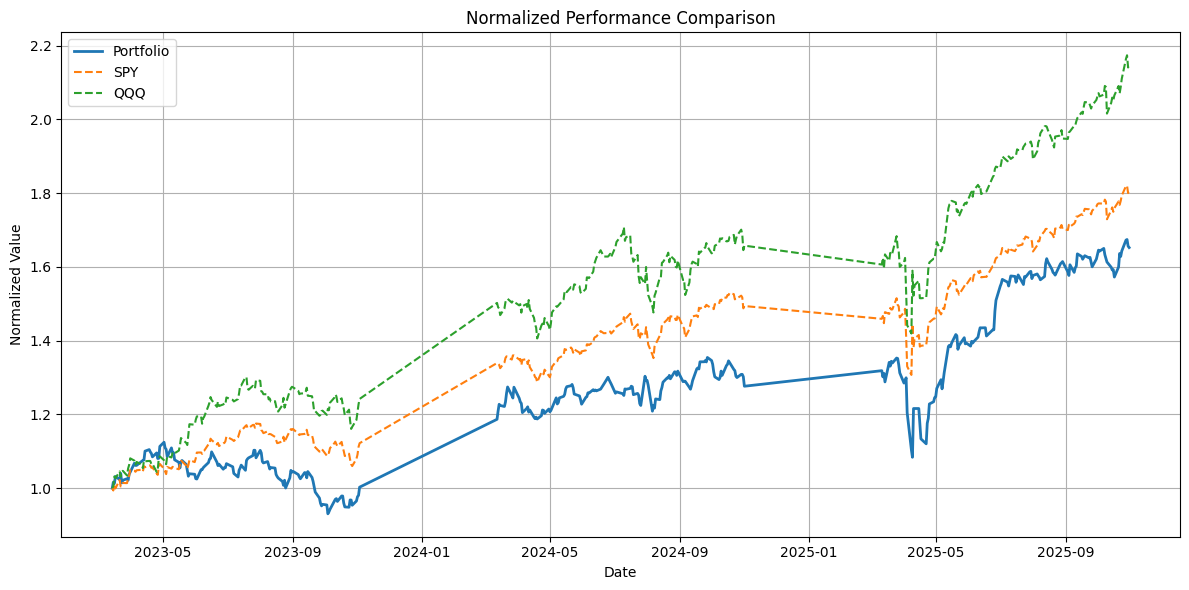

In [11]:
# Read Alpaca account history and compare against benchmarks (SPY/QQQ)
import logging
from datetime import datetime, timedelta, timezone
from src.trading.performance_analyzer import (
    create_alpaca_account_from_env, AlpacaManager,
    get_first_order_date, get_portfolio_history,
    get_benchmark_data, display_metrics_table, plot_performance
)

try:
    logging.basicConfig(level=logging.INFO)
    # Create AlpacaManager
    account = create_alpaca_account_from_env()
    manager = AlpacaManager([account])

    # Time range: from first order date to now (you can also customize the window)
    end_date = datetime.now(timezone.utc)
    first_order_date = get_first_order_date(manager)
    if first_order_date is None:
        raise RuntimeError('Cannot determine first order date — ensure account has trade history or check API permissions')

    # Ensure we fetch data through end_date (FMP requires +1 day), and start_date-1 for boundary
    start_date = first_order_date - timedelta(days=1)
    start_date_str = start_date.date().isoformat()
    fmp_end_date = end_date + timedelta(days=1)
    end_date_str = fmp_end_date.date().isoformat()

    # Fetch account equity curve and benchmark data
    portfolio_df = get_portfolio_history(manager, start_date, end_date)
    benchmark_df = get_benchmark_data(start_date_str, end_date_str)

    # Align metrics and plot (handles alignment and nulls internally)
    display_metrics_table(portfolio_df, benchmark_df)
    plot_performance(portfolio_df, benchmark_df)

except Exception as e:
    print('Paper trading performance analysis failed:', e)
    print('To enable this cell, configure Alpaca API in .env and ensure the account has order history.')

## Cancel All Open Alpaca Orders (Paper Trading)

Use this cell to batch-cancel all pending (open) orders in your Alpaca paper trading account.
This is useful when you want to revoke a rebalance before it executes, or clean up stale orders.

**When to run:** Only as needed — e.g., if you submitted orders by mistake or want to cancel before market open.

In [ ]:
# Batch cancel all open orders
from src.trading.performance_analyzer import create_alpaca_account_from_env, AlpacaManager

try:
    account = create_alpaca_account_from_env()
    manager = AlpacaManager([account])

    # Query current open orders
    open_orders = manager.get_orders(status='open', limit=200)
    print('Open orders:', len(open_orders))

    # Cancel all
    cancelled = manager.cancel_all_orders()
    print('Cancelled orders:', cancelled)

except Exception as e:
    print('Failed to cancel open orders:', e)
    print('Please verify Alpaca API is configured and the account is set to Paper Trading.')
